In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
# import catboost as cb
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor
# import gridsearchcv
from sklearn.model_selection import GridSearchCV


In [15]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1437) (294, 1437) (530, 1437) (803, 1437)


In [16]:
train[(cols_per_type(train, 'Ordered Categorical'))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1824 to 3219
Columns: 469 entries, f1b26 to cm5povca
dtypes: float64(469)
memory usage: 4.2 MB


In [17]:
meta.head(5)

,varlab,type,one_topic,dtype
new_name,,,,
f1a2,Were you present at the birth?,Binary,parenting,float64
f1a3,Have you held baby(ies)?,Binary,parenting,float64
f1a4,Will the baby(ies) have your last name?,Binary,parenting,float64
f1a5,Will your name be on the birth certificate?,Binary,parenting,float64
f1a6,Do you have other biological children?,Binary,health_and_health_behavior,float64


# Model

In [44]:
def run_model(train, test, target='gpa', classifier=False):

    catcols = train.select_dtypes(include=['category']).columns
    # transform to string
    train[catcols] = train[catcols].astype(str)
    test[catcols] = test[catcols].astype(str)
    

    X_train, y_train = prepare_data(train, target)
    X_test, y_test = prepare_data(test, target)


    print(X_train.shape, y_train.shape)
    

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'Total number of numerical features: {len(numerical_features)}')
    ordinal_features = cols_per_type(X_train, 'Ordered Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'Total number of binary features: {len(binary_features)}')
    categorical_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'Total number of categorical features: {len(categorical_features)}')
    print(f'Total number of ordinal features: {len(ordinal_features)}')



    if classifier:
        score = 'neg_brier_score'
        catboost = CatBoostClassifier(
            eval_metric='Logloss', loss_function='Logloss', thread_count=-1,cat_features=categorical_features,verbose=0)
        # search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)}
        
    else:
        catboost = CatBoostRegressor(thread_count=-1,cat_features=categorical_features, random_seed=123,
                                     iterations=20_000,early_stopping_rounds=1_000)
        
        score = 'neg_mean_squared_error'


    param_grid = {
        'learning_rate': [0.01, 0.1],
        'depth': [4, 10],
        'l2_leaf_reg': [2, 5],
    }

    
    # model = GridSearchCV(catboost, parameters, cv=5, n_jobs=-1, verbose=0, scoring=score)

    # model = catboost.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=100,plot=True)

    # grid search

    # model = GridSearchCV(catboost, param_grid, cv=5, n_jobs=-1,scoring=score).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=1_000)
    # bayes search
    model = BayesSearchCV(catboost, param_grid, cv=5, n_jobs=-1,scoring=score,verbose=20,n_iter=5).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)

    return model


# GPA

In [19]:
# run_model(train, test, target='gpa', classifier=False).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0,plot=True)

gpa_model = run_model(train,test,target='gpa', classifier=False)

(937, 1431) (937,)
Total number of numerical features: 135
Total number of binary features: 692
Total number of categorical features: 135
Total number of ordinal features: 469
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124..
[CV 2/5; 1/1] START depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124..
[CV 4/5; 1/1] START depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124..
[CV 5/5; 1/1] START depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124..
[CV 3/5; 1/1] START depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124..
[CV 2/5; 1/1] END depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124;, score=-0.439 total time= 2.8min
[CV 4/5; 1/1] END depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124;, score=-0.347 total time= 2.8min
[CV 1/5; 1/1] END depth=6, l2_leaf_reg=2, learning_rate=0.034707855520970124;, score=-0.361 total time= 2.8min
[CV 5/5; 1/1] END depth=6, 

In [20]:
gpa_model.best_score_

-0.37983281274640024

In [21]:
# Woodcock-Johnson Test 10 standard score
#  f3b3	0.01004	How many times have you been apart for a week or more?
#  m2c3j	0.00904	How many days a week does father put child to bed?

In [22]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Metric: mean_squared_error
Best CV score: 0.3798
Standard deviation of CV scores: 0.0321
Mean CV score: 0.3817
Test MSE: 0.4105
Test R2: 0.0980
Leaderboard MSE: 0.4748
Leaderboard R2: -0.2155
Holdout MSE: 0.5023
Holdout R2: -0.1897


In [24]:
# shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [26]:
model_materialHardship = run_model(train,test, target='materialHardship', classifier=False)

(1167, 1431) (1167,)
Total number of numerical features: 135
Total number of binary features: 692
Total number of categorical features: 135
Total number of ordinal features: 469
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089....
[CV 3/5; 1/1] START depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089....
[CV 2/5; 1/1] START depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089....
[CV 5/5; 1/1] START depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089....[CV 4/5; 1/1] START depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089....

[CV 2/5; 1/1] END depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089;, score=-0.022 total time= 6.9min
[CV 1/5; 1/1] END depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089;, score=-0.019 total time= 7.0min
[CV 5/5; 1/1] END depth=9, l2_leaf_reg=3, learning_rate=0.0653200687909089;, score=-0.020 total time= 7.1min
[CV 4/5; 1/1] END depth=9, l2_l

In [28]:
model_materialHardship.best_params_

OrderedDict([('depth', 8),
             ('l2_leaf_reg', 2),
             ('learning_rate', 0.043147769542643766)])

In [29]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

# run after here

Metric: mean_squared_error
Best CV score: 0.0198
Standard deviation of CV scores: 0.0016
Mean CV score: 0.0200
Test MSE: 0.0231
Test R2: 0.1519
Leaderboard MSE: 0.0330
Leaderboard R2: -0.1536
Holdout MSE: 0.0295
Holdout R2: -0.2116


In [32]:
# shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [34]:
model_grit = run_model(train,test, target='grit', classifier=False)

(1136, 1431) (1136,)
Total number of numerical features: 135
Total number of binary features: 692
Total number of categorical features: 135
Total number of ordinal features: 469
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5; 1/1] START depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822...
[CV 5/5; 1/1] START depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822...[CV 4/5; 1/1] START depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822...[CV 1/5; 1/1] START depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822...


[CV 2/5; 1/1] START depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822...
[CV 2/5; 1/1] END depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822;, score=-0.285 total time=  56.4s
[CV 3/5; 1/1] END depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822;, score=-0.214 total time=  57.2s
[CV 5/5; 1/1] END depth=4, l2_leaf_reg=3, learning_rate=0.08758214206860822;, score=-0.217 total time=  57.7s
[CV 1/5; 1/1] END depth=4, l

In [35]:
# Value 2 for “(He/she) stares blankly.”
#  hv4r10a_3_1	0.01520	Value 1 for “Any hazardous condition 3: broken glass”
#  hv5_wj9raw	0.00946	Woodcock-Johnson Test 9 raw score

In [39]:
model_grit.best_params_

OrderedDict([('depth', 4),
             ('l2_leaf_reg', 3),
             ('learning_rate', 0.08758214206860822)])

In [40]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2295
Standard deviation of CV scores: 0.0285
Mean CV score: 0.2321
Test MSE: 0.0023
Test R2: 0.9901
Leaderboard MSE: 0.6261
Leaderboard R2: -1.8492
Holdout MSE: 0.6657
Holdout R2: -1.7867


In [41]:
# shap_show(model_grit, alldata, target='grit')

# Eviction

In [45]:
model_eviction = run_model(train,test,target='eviction', classifier=True)

(1168, 1431) (1168,)
Total number of numerical features: 135
Total number of binary features: 692
Total number of categorical features: 135
Total number of ordinal features: 469
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076..
[CV 2/5; 1/1] START depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076..
[CV 5/5; 1/1] START depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076..
[CV 4/5; 1/1] START depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076..
[CV 3/5; 1/1] START depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076..
[CV 2/5; 1/1] END depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076;, score=-0.060 total time= 4.1min
[CV 3/5; 1/1] END depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076;, score=-0.059 total time= 4.1min
[CV 5/5; 1/1] END depth=8, l2_leaf_reg=4, learning_rate=0.057855217977802076;, score=-0.055 total time= 4.1min
[CV 4/5; 1/1] END depth=8

In [ ]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.0515
Test F1: 0.0000
Leaderboard Brier: 0.0660
Leaderboard F1: 0.0541


In [ ]:
# Value “yes” for “Telephone service disconnected because wasn’t enough money in past 12 months.”
#  m5f23c_1	0.05842	Value “yes” for “Did not pay full amount of rent/mortgage payments in past 12 months.”
#  m3i4	0.02062	How much rent do you pay each month?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


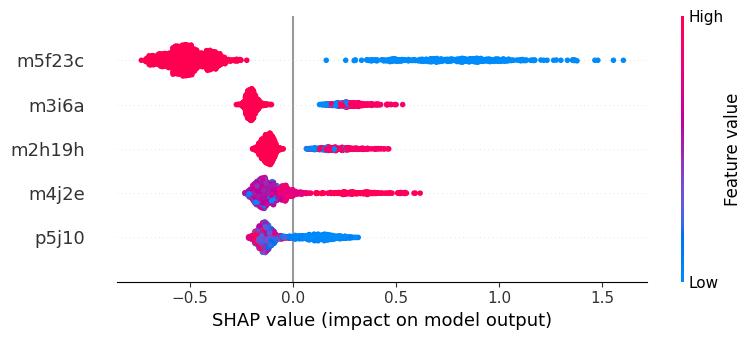

{('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'p5j10',
 ('In past year, was telephone service ever disconnected?',): 'm4j2e',
 ('In past year, did your-Telephone service get disconnected for nonpayment?',): 'm2h19h',
 ('How much do you weigh?',): 'm3i6a',
 ('J10. Amount of money spent eating out in last month',): 'm5f23c'}

In [ ]:
shap_show(model_eviction, alldata, target='eviction')

In [ ]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [ ]:
# Value “yes” for “In the last 2 years, have you taken any classes to improve your job skills?”
#  m5i1_1	0.06355	Value “yes” for “You are currently attending any school/trainings program/classes.”
#  m5i3b_1	0.06355	Value “yes” for “You have taken classes to improve job skills since last interview.”

In [48]:
model_job = run_model(train,test,target='jobTraining', classifier=True)

(1169, 1431) (1169,)
Total number of numerical features: 135
Total number of binary features: 692
Total number of categorical features: 135
Total number of ordinal features: 469
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128..
[CV 2/5; 1/1] START depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128..
[CV 3/5; 1/1] START depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128..
[CV 4/5; 1/1] START depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128..
[CV 5/5; 1/1] START depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128..
[CV 5/5; 1/1] END depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128;, score=-0.172 total time= 6.3min
[CV 1/5; 1/1] END depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128;, score=-0.167 total time= 6.4min
[CV 3/5; 1/1] END depth=10, l2_leaf_reg=3, learning_rate=0.03144706586596128;, score=-0.172 total time= 6.4min
[CV 4/5; 1/1] END depth=1

In [50]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.2671
Test F1: 0.0000
Leaderboard Brier: 0.2925
Leaderboard F1: 0.0000


In [49]:
# shap_show(model_job, alldata, target='jobTraining',n=5)

# Layoff

In [ ]:
# mount of money spent eating out in last month
#  m3i0q	0.01678	How important is it to serve in the military when at war?
#  f5i13	0.01678	How much you earn in that job, before taxes

In [51]:
model_layoff = run_model(train, test, target='layoff', classifier=True)

(1026, 1431) (1026,)
Total number of numerical features: 135
Total number of binary features: 692
Total number of categorical features: 135
Total number of ordinal features: 469
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543....
[CV 2/5; 1/1] START depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543....
[CV 3/5; 1/1] START depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543....
[CV 4/5; 1/1] START depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543....
[CV 5/5; 1/1] START depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543....
[CV 1/5; 1/1] END depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543;, score=-0.166 total time= 4.2min
[CV 2/5; 1/1] END depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543;, score=-0.167 total time= 4.2min
[CV 5/5; 1/1] END depth=8, l2_leaf_reg=2, learning_rate=0.0866585196203543;, score=-0.165 total time= 4.3min
[CV 3/5; 1/1] END depth=8, l2_l

In [ ]:
model_layoff.best_params_

OrderedDict([('regressor__learning_rate', 0.016032433969661176),
             ('regressor__max_depth', 9),
             ('regressor__scale_pos_weight', 7)])

In [ ]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Test Brier: 0.2231
Test F1: 0.0968
Leaderboard Brier: 0.2528
Leaderboard F1: 0.1067
Holdout Brier: 0.2428


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


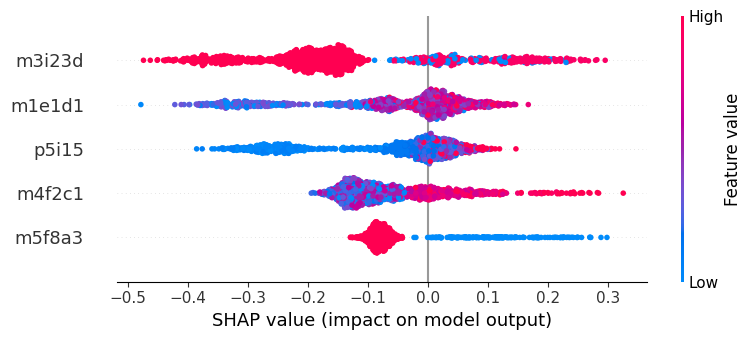

{('In past year, did you not pay full gas/oil/electricity bill?',): 'm5f8a3',
 ('People who currently live in your HH - 1st age?',): 'm4f2c1',
 ('I15. Number of hours TV is on',): 'p5i15',
 ("What is first person's age? (years)",): 'm1e1d1',
 ('F8A3. Received income from other assistance in last 12 months',): 'm3i23d'}

In [ ]:
# shap_show(model_layoff, alldata, target='layoff')